# MOC computation

If you would like to try to repeat examples from this notebook, you can download FESOM2 data and mesh. The data are quite heavy, about 15 Gb.

Link: https://swiftbrowser.dkrz.de/public/dkrz_c719fbc3-98ea-446c-8e01-356dac22ed90/PYFESOM2/

You have to download both archives (`LCORE.tar` and `LCORE_MESH.tar`) and extract them. 

Alternative would be to use very light weight mesh that comes with pyfesom2 in the `tests/data/pi-grid/` and example data on this mesh in `tests/data/pi-results`.

In [13]:
import pyfesom2 as pf
import matplotlib.cm as cm
import matplotlib.pylab as plt
import numpy as np

In [4]:
mesh = pf.load_mesh('/Users/koldunovn/PYHTON/DATA/LCORE_MESH/', 
                    abg=[50, 15, -90])

/Users/koldunovn/PYHTON/DATA/LCORE_MESH/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/koldunovn/PYHTON/DATA/LCORE_MESH/pickle_mesh_py3_fesom2


In [6]:
data = pf.get_data('../../DATA/LCORE/', 'w', range(1950,1959), mesh, how="mean", compute=True )

Depth is None, 3d field will be returned


In [28]:
data.shape

(126858, 48)

Minimum nessesary input is mesh and one 3D field of w.

In [34]:
lats, moc = pf.xmoc_data(mesh, data)

You get latitides and the MOC values (global by default). They can be used to plot the MOC using hofm_plot function:

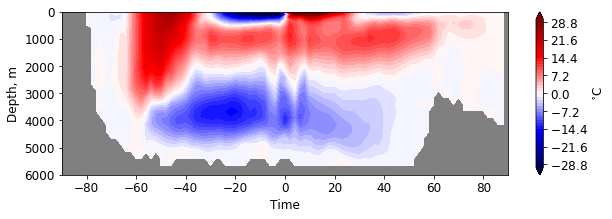

In [35]:
plt.figure(figsize=(10, 3))
pf.hofm_plot(mesh, moc, xvals=lats, maxdepth=7000, cmap=cm.seismic, levels = np.linspace(-30, 30, 51), 
             facecolor='gray')

Increase the number of latitude bins:

In [36]:
lats, moc = pf.xmoc_data(mesh, data, nlats=200)

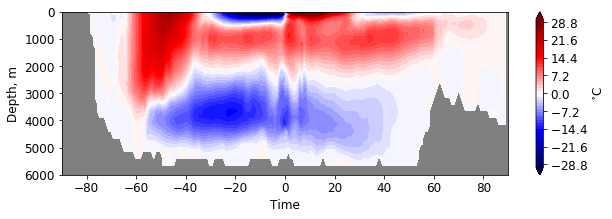

In [37]:
plt.figure(figsize=(10, 3))
pf.hofm_plot(mesh, moc, xvals=lats, maxdepth=7000, cmap=cm.seismic, levels = np.linspace(-30, 30, 51), 
             facecolor='gray')

You can define the region for MOC computation.

In [38]:
lats, moc = pf.xmoc_data(mesh, data, mask="Atlantic_MOC")

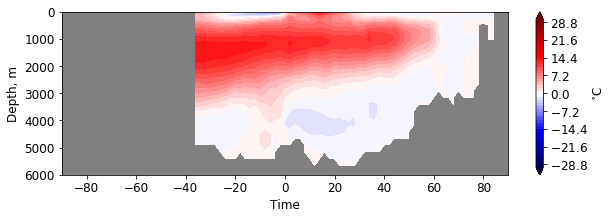

In [39]:
plt.figure(figsize=(10, 3))
pf.hofm_plot(mesh, moc, xvals=lats, maxdepth=7000, cmap=cm.seismic, levels = np.linspace(-30, 30, 51), 
             facecolor='gray')

Regions are listed in documentation of pf.get_mask. Currently they are:

       Ocean Basins:
            "Atlantic_Basin"
            "Pacific_Basin"
            "Indian_Basin"
            "Arctic_Basin"
            "Southern_Ocean_Basin"
            "Mediterranean_Basin"
            "Global Ocean"
            "Global Ocean 65N to 65S"
            "Global Ocean 15S to 15N"
        MOC Basins:
            "Atlantic_MOC"
            "IndoPacific_MOC"
            "Pacific_MOC"
            "Indian_MOC"
        Nino Regions:
            "Nino 3.4"
            "Nino 3"
            "Nino 4"

You can combine masks:

In [49]:
mask1 = pf.get_mask(mesh, "Atlantic_Basin")
mask2 = pf.get_mask(mesh, "Arctic_Basin")
mask3 = mask1|mask2

Check how the masked data looks like:

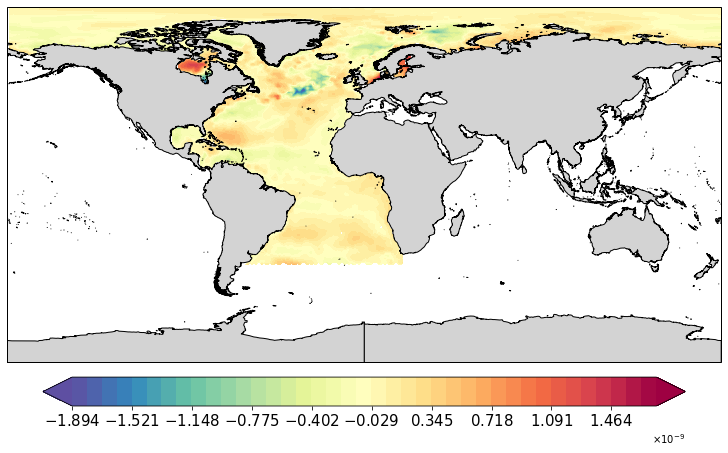

In [50]:
pf.plot(mesh, data[:,0]*mask3)

You can then provide combined mask to `xmoc_data`:

In [61]:
lats, moc = pf.xmoc_data(mesh, data, mask=mask3)

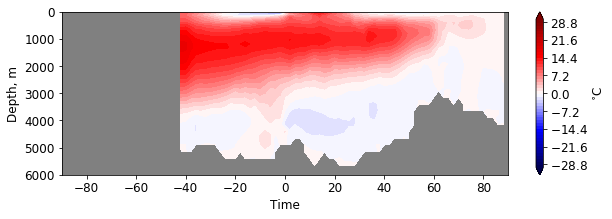

In [62]:
plt.figure(figsize=(10, 3))
pf.hofm_plot(mesh, moc, xvals=lats, maxdepth=7000, cmap=cm.seismic, levels = np.linspace(-30, 30, 51), 
             facecolor='gray')

If you work with large meshes, it makes sence to compute some data beforehand and provide them to the function:

In [63]:
meshdiag = pf.get_meshdiag(mesh)
el_area = meshdiag['elem_area'][:]
nlevels = meshdiag['nlevels'][:]-1
face_x, face_y = pf.compute_face_coords(mesh)
mask = pf.get_mask(mesh, 'Global Ocean')

In [64]:
lats, moc = pf.xmoc_data(mesh, data, mask = mask, 
                el_area = el_area, nlevels=nlevels, 
                face_x=face_x, face_y=face_y)

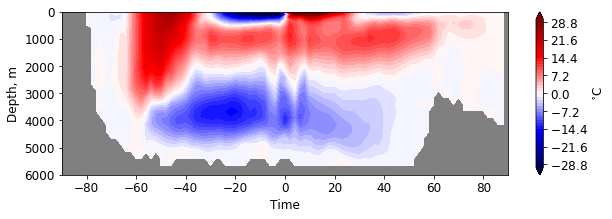

In [65]:
plt.figure(figsize=(10, 3))
pf.hofm_plot(mesh, moc, xvals=lats, maxdepth=7000, cmap=cm.seismic, levels = np.linspace(-30, 30, 51), 
             facecolor='gray')

## Compute AMOC at 26.5N

Open data as time series

In [88]:
data = pf.get_data('../../DATA/LCORE/', 'w', range(1950,1959), mesh, how="ori", compute=False )

Depth is None, 3d field will be returned


In [89]:
data

<xarray.DataArray 'w' (time: 9, nod2: 126858, nz: 48)>
dask.array<concatenate, shape=(9, 126858, 48), dtype=float32, chunksize=(1, 126858, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-12-31T23:15:00 ... 1958-12-31T23:15:00
Dimensions without coordinates: nod2, nz
Attributes:
    description:  vertical velocity
    units:        m/s

We have 9 time steps

In [90]:
data.shape

(9, 126858, 48)

Compute AMOC for each time step, increase the number of latitudes if you want to be preciselly at 26.5:

In [109]:
moc = []

for i in range(data.shape[0]):
    lats, moc_time = pf.xmoc_data(mesh, data[i,:,:], mask='Atlantic_MOC', nlats=361)
    moc.append(moc_time)

Find which index corresponds to 26.5

In [110]:
lats[233]

26.5

Compute maximum at this point for each time step:

In [113]:
amoc26 = []
for i in range(len(moc)):
    amoc26.append(moc[i][233,:].max())

In [114]:
amoc26

[11.871677395438851,
 12.17447911245645,
 11.634695012527837,
 12.611884810155964,
 12.354251356017224,
 10.003526012070289,
 11.40134476396998,
 10.713783333512506,
 10.583684577084185]

You can use time information from original dataset for plotting:

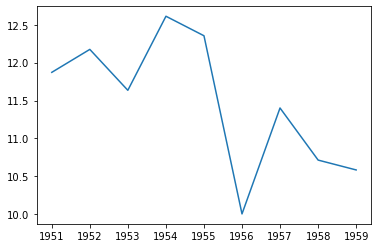

In [116]:
plt.plot(data.time, amoc26)